In [ ]:
!pip install pymc arviz numpy pandas matplotlib --quiet


In [14]:
from google.colab import drive
drive.mount('/content/drive')
data = 'content/drive/MyDrive/ml-latest-small/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import pymc as pm
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 数据准备

ratings = pd.read_csv('/content/drive/MyDrive/ml-latest-small/ratings.csv')
movies = pd.read_csv('/content/drive/MyDrive/ml-latest-small/movies.csv')

# 选择活跃用户和热门电影
user_counts = ratings['userId'].value_counts()
movie_counts = ratings['movieId'].value_counts()
active_users = user_counts[user_counts >= 20].index
popular_movies = movie_counts[movie_counts >= 50].index

filtered_ratings = ratings[ratings['userId'].isin(active_users) &
                          ratings['movieId'].isin(popular_movies)]

# 创建映射字典
user_ids = filtered_ratings['userId'].unique()
movie_ids = filtered_ratings['movieId'].unique()
user_id_map = {uid: i for i, uid in enumerate(user_ids)}
movie_id_map = {mid: i for i, mid in enumerate(movie_ids)}

# 转换为连续索引
filtered_ratings['user_idx'] = filtered_ratings['userId'].map(user_id_map)
filtered_ratings['movie_idx'] = filtered_ratings['movieId'].map(movie_id_map)

# 标准化评分
scaler = StandardScaler()
filtered_ratings['rating_norm'] = scaler.fit_transform(filtered_ratings[['rating']])

# 定义模型维度
num_users = len(user_ids)
num_movies = len(movie_ids)
K = 10  # 潜在因子维度

with pm.Model() as bayesian_pmf:
    # 用户和电影潜在因子矩阵
    U = pm.Normal("U", mu=0, sigma=0.1, shape=(num_users, K))
    V = pm.Normal("V", mu=0, sigma=0.1, shape=(num_movies, K))

    # 偏置项
    user_bias = pm.Normal("user_bias", mu=0, sigma=0.1, shape=num_users)
    movie_bias = pm.Normal("movie_bias", mu=0, sigma=0.1, shape=num_movies)
    global_bias = pm.Normal("global_bias", mu=0, sigma=0.1)

    # 预测评分
    r_hat = global_bias + user_bias[filtered_ratings['user_idx']] + \
            movie_bias[filtered_ratings['movie_idx']] + \
            pm.math.sum(U[filtered_ratings['user_idx']] * V[filtered_ratings['movie_idx']], axis=1)

    # 观测噪声
    sigma = pm.HalfNormal("sigma", sigma=0.5)

    # 似然函数
    R = pm.Normal("R", mu=r_hat, sigma=sigma, observed=filtered_ratings['rating_norm'])

    # 采样
    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        return_inferencedata=True
    )

<ipython-input-17-0598fd6cc789>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ratings['user_idx'] = filtered_ratings['userId'].map(user_id_map)
<ipython-input-17-0598fd6cc789>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ratings['movie_idx'] = filtered_ratings['movieId'].map(movie_id_map)
<ipython-input-17-0598fd6cc789>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Output()

In [37]:
import arviz as az


display(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"U[0, 0]",-0.002,0.098,-0.177,0.186,0.001,0.002,6396.0,2766.0,1.0
"U[0, 1]",-0.001,0.102,-0.184,0.195,0.001,0.002,6577.0,2892.0,1.0
"U[0, 2]",0.000,0.100,-0.184,0.190,0.001,0.002,6280.0,2760.0,1.0
"U[0, 3]",-0.001,0.099,-0.182,0.189,0.001,0.002,5975.0,2829.0,1.0
"U[0, 4]",-0.001,0.096,-0.174,0.184,0.001,0.002,7167.0,3033.0,1.0
...,...,...,...,...,...,...,...,...,...
user_bias[601],-0.037,0.049,-0.130,0.054,0.001,0.001,7427.0,2904.0,1.0
user_bias[602],0.035,0.067,-0.098,0.158,0.001,0.001,6771.0,2339.0,1.0
user_bias[603],-0.284,0.045,-0.372,-0.203,0.001,0.001,5321.0,2956.0,1.0
user_bias[604],-0.096,0.087,-0.267,0.059,0.001,0.002,6102.0,2490.0,1.0


In [24]:
import arviz as az

az.to_netcdf(trace, "pmf_trace.nc")


'pmf_trace.nc'

In [25]:

trace = az.from_netcdf("pmf_trace.nc")


In [34]:
import arviz as az
import numpy as np

u = 0
m = 0


U_all = trace.posterior["U"].stack(sample=("chain", "draw")).transpose("sample", "U_dim_0", "U_dim_1").values  # shape: [samples, num_users, K]
V_all = trace.posterior["V"].stack(sample=("chain", "draw")).transpose("sample", "V_dim_0", "V_dim_1").values
user_bias_all = trace.posterior["user_bias"].stack(sample=("chain", "draw")).transpose("sample", "user_bias_dim_0").values  # [samples, num_users]
movie_bias_all = trace.posterior["movie_bias"].stack(sample=("chain", "draw")).transpose("sample", "movie_bias_dim_0").values
global_bias_all = trace.posterior["global_bias"].stack(sample=("chain", "draw")).values.flatten()  # [samples]

# shape = [samples, K]
u_vec = U_all[:, u, :]
v_vec = V_all[:, m, :]

dot = np.sum(u_vec * v_vec, axis=1)

pred_z = dot + user_bias_all[:, u] + movie_bias_all[:, m] + global_bias_all

pred = pred_z * rating_std + rating_mean


print(f"[User {u}, Movie {m}] Predicted Rating = {pred.mean():.2f}, 95% CI: ({np.percentile(pred, 2.5):.2f} ~ {np.percentile(pred, 97.5):.2f})")


[User 0, Movie 0] Predicted Rating = 4.30, 95% CI: (4.15 ~ 4.45)


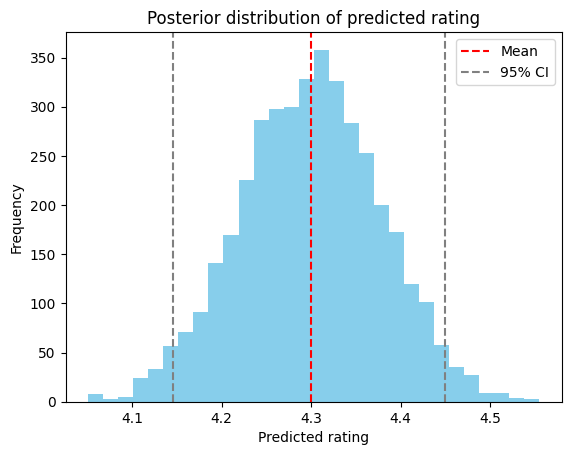

In [35]:
import matplotlib.pyplot as plt

plt.hist(pred, bins=30, color='skyblue')
plt.axvline(pred.mean(), color='red', linestyle='--', label='Mean')
plt.axvline(np.percentile(pred, 2.5), color='gray', linestyle='--', label='95% CI')
plt.axvline(np.percentile(pred, 97.5), color='gray', linestyle='--')
plt.title("Posterior distribution of predicted rating")
plt.xlabel("Predicted rating")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [36]:
for u, m in [(0,0), (1,3), (5,10), (12,15), (20,25)]:
    u_vec = U_all[:, u, :]
    v_vec = V_all[:, m, :]
    dot = np.sum(u_vec * v_vec, axis=1)
    pred_z = dot + user_bias_all[:, u] + movie_bias_all[:, m] + global_bias_all
    pred = pred_z * rating_std + rating_mean
    print(f"[User {u}, Movie {m}] Predicted Rating = {pred.mean():.2f}, 95% CI: ({np.percentile(pred, 2.5):.2f} ~ {np.percentile(pred, 97.5):.2f})")


[User 0, Movie 0] Predicted Rating = 4.30, 95% CI: (4.15 ~ 4.45)
[User 1, Movie 3] Predicted Rating = 4.00, 95% CI: (3.81 ~ 4.20)
[User 5, Movie 10] Predicted Rating = 3.91, 95% CI: (3.72 ~ 4.10)
[User 12, Movie 15] Predicted Rating = 3.82, 95% CI: (3.60 ~ 4.02)
[User 20, Movie 25] Predicted Rating = 3.45, 95% CI: (3.31 ~ 3.60)


In [39]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(
    filtered_ratings,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")


Train size: 33088, Test size: 8272


In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


preds = []
true = []

for _, row in test_df.iterrows():
    u = int(row["user_idx"])
    m = int(row["movie_idx"])

    u_vec = U_all[:, u, :]  # shape: [samples, K]
    v_vec = V_all[:, m, :]  # shape: [samples, K]

    dot = np.sum(u_vec * v_vec, axis=1)
    pred_z = dot + user_bias_all[:, u] + movie_bias_all[:, m] + global_bias_all
    pred = pred_z * rating_std + rating_mean

    preds.append(pred.mean())
    true.append(row["rating"])

# RMSE & MAE
rmse = np.sqrt(mean_squared_error(true, preds))
mae = mean_absolute_error(true, preds)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")


Test RMSE: 0.8642
Test MAE: 0.6551
